In [1]:
from data import Data
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data = Data(0.01,1000,0.)
X, Y = data[150]
X = X.unsqueeze(-1)
Y = Y
print(X.shape,Y.shape)

torch.Size([850, 150, 1]) torch.Size([850, 1])


In [3]:
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size=100, shuffle=False)

In [4]:
class RNN_model(nn.Module):
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens, batch_first=True)
        self.linear = nn.Linear(num_hiddens, num_out)
    def forward(self, X, H):
        state, H = self.rnn(X,H)
        pred = self.linear(H[0]) #checked! H[0]=state[:,-1,:]
        return pred # size = (batch_size, 1)

In [5]:
def rnn_train(model, dl_train, optimizer, loss, hidden_size, device = 'cpu'):
    total_loss = 0
    for X, Y in dl_train:
        model.train()
        X, Y = X.to(device), Y.to(device)
        H = torch.zeros(1,X.shape[0],hidden_size)
        Y_hat = model(X,H)
        batch_loss = loss(Y_hat,Y)
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.detach()
    total_loss = torch.sqrt(total_loss/len(ds))
    if epoch %10 ==0:
        print(total_loss) MSE loss

In [10]:
hidden_size = 2
mse_loss = nn.MSELoss(reduction='sum')
rnn_model = RNN_model(1,hidden_size)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
for epoch in range(1000):
    rnn_train(rnn_model, dl, optimizer, mse_loss, hidden_size)

tensor(0.6348)
tensor(0.6293)
tensor(0.6221)
tensor(0.6143)
tensor(0.6058)
tensor(0.5964)
tensor(0.5861)
tensor(0.5751)
tensor(0.5633)
tensor(0.5506)
tensor(0.5369)
tensor(0.5225)
tensor(0.5072)
tensor(0.4909)
tensor(0.4738)
tensor(0.4557)
tensor(0.4367)
tensor(0.4170)
tensor(0.3965)
tensor(0.3753)
tensor(0.3534)
tensor(0.3308)
tensor(0.3074)
tensor(0.2833)
tensor(0.2586)
tensor(0.2333)
tensor(0.2079)
tensor(0.1824)
tensor(0.1566)
tensor(0.1307)
tensor(0.1056)
tensor(0.0833)
tensor(0.0657)
tensor(0.0555)
tensor(0.0593)
tensor(0.0765)
tensor(0.0985)
tensor(0.1212)
tensor(0.1457)
tensor(0.1711)
tensor(0.1944)
tensor(0.2164)
tensor(0.2384)
tensor(0.2581)
tensor(0.2745)
tensor(0.2895)
tensor(0.3021)
tensor(0.3104)
tensor(0.3164)
tensor(0.3200)
tensor(0.3192)
tensor(0.3144)
tensor(0.3076)
tensor(0.2982)
tensor(0.2850)
tensor(0.2703)
tensor(0.2555)
tensor(0.2391)
tensor(0.2207)
tensor(0.2031)
tensor(0.1879)
tensor(0.1731)
tensor(0.1580)
tensor(0.1461)
tensor(0.1395)
tensor(0.1354)
tensor(0.1

Analyze the learning pattern. Even though loss is not stable, the model is able to minimize the loss since Adam optimizer decreases lr gradually.

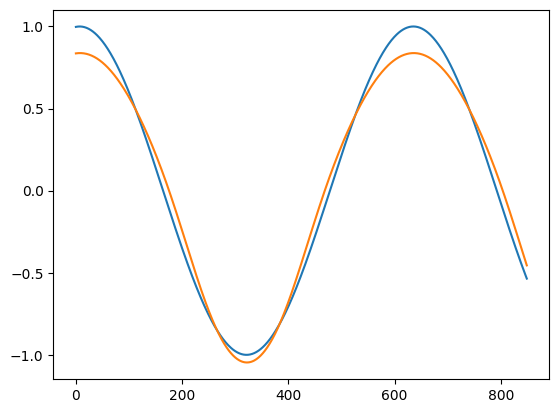

In [12]:
H = torch.zeros(1,850,2)
a = rnn_model(X,H).detach()
plt.plot(data.x[150:])
plt.plot(a)

In [141]:
def predictor(X,k):
    '''Calculates first (len(X)) predictions from given data X, then using the prediction data,
    calculates next k-step predictions.
    '''
    H_0 = torch.zeros(1,X.shape[0],2) # size (1,850,2)
    X_0 = rnn_model(X,H).detach() #size (850,1)
    X_next = torch.cat([X[-1,1:],X_0[-1].unsqueeze(-1)]) #first prediction concatinated with the last 149 values. size(150,1)
    H_next = torch.zeros(1,2)
    for i in range(k):
        X_next = torch.cat([X_next[1:],rnn_model(X_next,H_next).detach().unsqueeze(-1)]) 
        X_0 = torch.cat([X_0,X_next[-1].unsqueeze(-1)])
    return X_0 # This messy code is correct. Analyzed the results in detail.

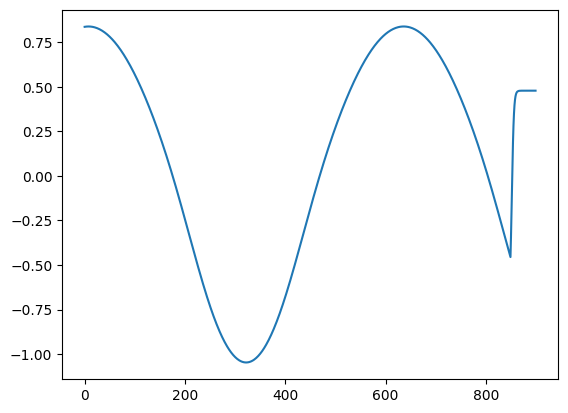

In [144]:
result = predictor(X,50)
plt.plot(result)

Our code works for 1-step predictions but explodes quickly for further predictions since we only used teacher forcing. To resolve this, we may use an autoregressive model.